In [1]:
import matplotlib.pyplot as plt
from torch import nn
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import math
import warnings
import torchvision
import numpy as np
from scipy import interpolate
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

## Synthesis Data

In [15]:
def sim_data(n, dim, Type):
    
    #noise = torch.normal(0, noiseL, size=(n, 1))

    if Type == 'A':
        X = torch.rand((n, dim))
        y = 1
        for d in range(dim):
            a = (d+1)/2
            y *= ((torch.abs(4*X[:,d]-2)+a)/(1+a))
        y = y.reshape(-1,1)
        y = y.float()

    elif Type == 'B':
        X = torch.rand((n, dim))
        y = torch.zeros((n))
        for i in range(dim):
            y += ((-1**(i+1)/(i+1))*X[:,i])
        y = y.reshape(-1,1)
        y = -y.float()
        
    elif Type == 'C':
        # noise level should be 0.01
        X = torch.rand((n, 4))
        y = torch.exp(X[:,0]**2-torch.sqrt(X[:,1]+5))+0.01*torch.arctan(1/(0.01+torch.abs(X[:,2]+X[:,3])))
        y = y.reshape(-1,1)
        y = y.float()

    elif Type == 'D':
        X = torch.rand((n,dim))
        y = torch.exp(2*torch.sin(X[:,0]*0.5*torch.pi)+ 0.5*torch.cos(X[:,1]*2.5*torch.pi))
        y = y.reshape(-1,1)
        y = y.float()
    
    return X, y


def diag_mat_weights(dimp, type = 'first'):
    if type == 'first':
        dg = np.zeros((dimp-1, dimp))
        for i in range(dimp-1):
            dg[i,i] = -1
            dg[i,i+1]= 1
    elif type == 'second':
        dg = np.zeros((dimp-2, dimp))
        for i in range(dimp-2):
            dg[i,i] = -1
            dg[i,i+1]= 2
            dg[i,i+2]= -1
    else:
        pass
    return torch.Tensor(dg)

The following block describ the three functions we used in section 4.

$$
    \text{(Type A): }g^*_1(\textbf{x})= \left[\prod^p_{i=1}\frac{|4x_i-2|+a_i}{1+a_i}\right],\text{ where }a_i=i/2,i=1,\cdots,p
$$
$$
    \text{(Type B): }g^*_2(\textbf{x})= \sum_{i=1}^p(-1)^{i}i^{-1}x_i
$$
$$
    \text{(Type C): }g^*_3(\textbf{x})= \left[\exp\left(x_1^2-\sqrt{x_2+5}\right)+0.01\cot\left(\frac{1}{0.01+|x_3+x_4|}\right)\right]
$$

The user can decide which dataset they want to use to replicate the experiment.

In [16]:
print('which function you want to use to generate the simulated dataset?')
Type = input()

print('what is the dimension for the input?')
ndim = input()
ndim = int(ndim)

print('what is the size for the training set?')
trainsize = input()
trainsize = int(trainsize)

print('what is the size for the testing set?')
testsize = input()
testsize = int(testsize)

which function you want to use to generate the simulated dataset?


 D


what is the dimension for the input?


 10


what is the size for the training set?


 400


what is the size for the testing set?


 500


In [25]:
trainsize = 400; testsize = 800
error_ratio = 0.05
ndim = 10


# Training/ Testing
Type = 'D'
torch.manual_seed(0)
X_train, y_train = sim_data(trainsize, ndim, Type)
X_test, y_test = sim_data(testsize, ndim, Type)

eps_train = torch.normal(0, torch.var(y_train)*error_ratio, size=(trainsize, 1))
eps_test = torch.normal(0, torch.var(y_test)*error_ratio, size=(testsize, 1))

y_train += eps_train
y_test += eps_test
#np.savez_compressed('./dataset/stdex3n800.npz', Xtrain=X_train, ytrain=y_train, Xtest=X_test, ytest=y_test)

print(X_train.size(), y_train.size(), X_test.size(), y_test.size())

torch.Size([400, 10]) torch.Size([400, 1]) torch.Size([800, 10]) torch.Size([800, 1])


# Modeling

## DNN-S

In [26]:
class PRODBSplineLayerMultiFeature(nn.Module):
    def __init__(self, input_dim, degree, num_knots, output_dim, num_neurons, bias = True):
        super(PRODBSplineLayerMultiFeature, self).__init__()
        self.degree = degree
        self.num_knots = num_knots
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        
        if input_dim == 2:
            self.control_p = nn.Parameter(torch.randn(self.num_knots**2, self.output_dim))
        else:
            self.control_p = nn.Parameter(torch.randn(self.num_knots, self.num_neurons))
        if bias:
            self.bias = nn.Parameter(torch.randn(self.num_neurons))
        else:
            self.register_parameter('bias', None)
            
        self.inter = {}
    
    def basis_function(self, x, i, k, t):
    
        # Base case: degree 0 spline
        if k == 0:
            return ((t[i] <= x) & (x < t[i + 1])).float()
    
        # Recursive case
        denom1 = t[i + k] - t[i]
        denom2 = t[i + k + 1] - t[i + 1]
    
        term1 = 0
        if denom1 != 0:
            term1 = (x - t[i]) / denom1 * self.basis_function(x, i, k - 1, t)
    
        term2 = 0
        if denom2 != 0:
            term2 = (t[i + k + 1] - x) / denom2 * self.basis_function(x, i + 1, k - 1, t)
    
        return term1 + term2
    
    def forward(self, x):
        batch_size, num_features = x.size()
        device = x.device
        
        # Create knot vector
        # knots = torch.linspace(0, 1, self.num_knots + self.degree + 1).to(device)
        knots = torch.cat([
                        torch.zeros(self.degree),               # Add repeated values at the start for clamping
                        torch.linspace(0, 1, self.num_knots - self.degree + 1),  # Uniform knot spacing in the middle
                        torch.ones(self.degree)                 # Add repeated values at the end for clamping
                    ]).to(device)
        # Apply B-spline basis functions for each feature
        basises = []
    
        
        for feature in range(num_features):
            # Calculate B-spline basis functions for this feature
            basis = torch.stack([self.basis_function(x[:, feature], i, self.degree, knots) 
                                 for i in range(self.num_knots)], dim=-1)
            basises.append(basis)
            
        
        #if num_features == 1:
            #tout = basises[0] @ self.control_p
            #self.inter['eachbasic'] = basises[0].T
        #else:
        self.inter['eachbasic'] = torch.reshape(torch.stack(basises, dim = 1), (batch_size, self.num_knots * self.num_neurons)).T
        basises = torch.stack(basises)
        tout = basises.permute(1,2,0) * self.control_p
        tout = tout.sum(dim =1)
                
        if self.bias is not None:
            tout += self.bias        

        self.inter['basicoutput'] = tout
        return tout


class NormLayer(nn.Module):
    def __init__(self):
        super(NormLayer, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, axis = 1).values.reshape(-1,1)
        max_val = torch.max(x, axis = 1).values.reshape(-1,1)

        x = (x - min_val)/(max_val - min_val)  # Rescale to [0, 1]
        return x.detach()

In [27]:
class DNNS1(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, output_dim, bias):
        super(DNNS1, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.nm1 = NormLayer() 
        self.sp1 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        self.relu = nn.ReLU()
        self.inter = {}
        
    def forward(self, x):
        ln1out = self.ln1(x)
        ln1out = self.nm1(ln1out)
        
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        ln2out = self.ln2(sp1out)
        
        return ln2out

def num_para(model):
    tp = 0
    for param in model.parameters():
        tp += param.numel()
    return tp

### Experiment setting

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nm = 50; dg = 3; nk = 15; Fin = ndim; Fout = 1;
model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
print('Number of Parameters: ', num_para(model))

learning_r = 1e-1
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_r)
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = np.inf

Number of Parameters:  1401


### Simulated data training

In [29]:
for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = model(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat != 0) and (tpat != 0) and (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            #print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(model.state_dict(), './EXB'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        else:
            tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')

| Epoch:  1 / 10000  | Loss:  41.3508  |
| Epoch:  2 / 10000  | Loss:  9.1593  |
| Epoch:  3 / 10000  | Loss:  16.9424  |
| Epoch:  4 / 10000  | Loss:  17.1588  |
| Epoch:  5 / 10000  | Loss:  10.0133  |
| Epoch:  6 / 10000  | Loss:  8.2203  |
| Epoch:  7 / 10000  | Loss:  11.612  |
| Epoch:  8 / 10000  | Loss:  12.7268  |
| Epoch:  9 / 10000  | Loss:  10.0389  |
| Epoch:  10 / 10000  | Loss:  6.8685  |
| Epoch:  11 / 10000  | Loss:  6.0337  |
| Epoch:  12 / 10000  | Loss:  7.4142  |
| Epoch:  13 / 10000  | Loss:  8.3646  |
| Epoch:  14 / 10000  | Loss:  7.3568  |
| Epoch:  15 / 10000  | Loss:  5.5542  |
| Epoch:  16 / 10000  | Loss:  4.6739  |
| Epoch:  17 / 10000  | Loss:  5.1105  |
| Epoch:  18 / 10000  | Loss:  5.8845  |
| Epoch:  19 / 10000  | Loss:  5.91  |
| Epoch:  20 / 10000  | Loss:  5.0838  |
| Epoch:  21 / 10000  | Loss:  4.1645  |
| Epoch:  22 / 10000  | Loss:  3.9144  |
| Epoch:  23 / 10000  | Loss:  4.3322  |
| Epoch:  24 / 10000  | Loss:  4.6697  |
| Epoch:  25 / 10000 

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), './EXB'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))

(Train) MSPE:  tensor(0.0011) | (Test) MSPE:  tensor(0.0010)


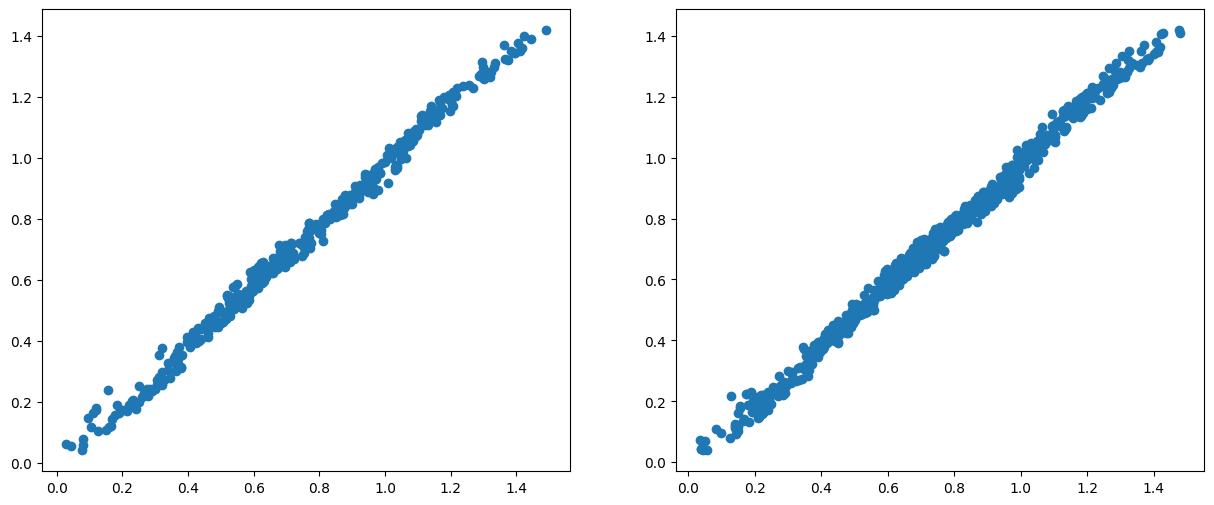

In [79]:
with torch.no_grad():
    eval_model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./EXB'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print('(Train) MSPE: ',criterion(y_train, eval_model(X_train).detach()), '| (Test) MSPE: ',criterion(y_test, eval_model(X_test).detach()))
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.scatter(y_train, eval_model(X_train).detach())
    plt.subplot(1,2,2)
    plt.scatter(y_test, eval_model(X_test).detach())

### ECM Tuning

In [55]:
def ECM(model, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi
    
    B = model.sp1.inter['eachbasic']
    By = model.sp1.inter['basicoutput']
    WB = model.sp1.control_p
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()

In [67]:
ECM_epoches = 10
with torch.no_grad():
    eval_model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./EXB'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))

    WB = eval_model.sp1.control_p
    DB = diag_mat_weights(WB.size()[0], 'second').to(device)
    BestGCV = 9999
    
    for i in range(ECM_epoches):
        MPSy = eval_model(X_train)
        LambdaB1 = ECM(model = eval_model, num_neurons = nm, num_knots = nk)        
        B1 = eval_model.sp1.inter['eachbasic']
        By1 = eval_model.sp1.inter['basicoutput']
        P2 = (torch.linalg.pinv(By1.T @ By1) @ By1.T @ By1)
        
        size1 = B1.size()[1]
        B1 = B1.view(nm, nk, size1)

        NW1 = torch.empty((nk, nm))
        NB1 = torch.empty((nm))
        for i in range(nm):
            B1y = By1[:,i] - eval_model.sp1.bias.data[i]
            BB1 = B1[i].T
            PB1 = (torch.linalg.pinv(BB1.T @ BB1) @ BB1.T @ BB1)
            
            # Update the weights and bias
            NW1[:, i] = (torch.inverse(BB1.T @ BB1 + (LambdaB1/size1) * (DB.T @ DB)) @ BB1.T @ B1y)
            NB1[i] = torch.mean(By1[:,i] - (NW1[:,i] @ BB1.T))
            
        # update the weight
        getattr(eval_model.sp1, 'control_p').data = NW1
        getattr(eval_model.sp1, 'bias').data = NB1
        

        MPSy = eval_model(X_train)
        trainloss = np.round(criterion(y_train, MPSy.detach()).item(), 5)
        GCV = np.round((torch.norm(y_train - MPSy)/(nm-torch.trace(P2))**2).item(), 5)
        
        if GCV < BestGCV:
            BestLambdaB = LambdaB1
            BestGCV = GCV
            
        #MPSy = eval_model(X_test)
        #print('Lambda: ', np.round(LambdaB1, 5),'| Training Loss: ', trainloss,'| GCV: ', GCV,' | Testing Error: ', np.round(criterion(y_test, MPSy.detach()).item(), 5))

In [227]:
"""
Lambdalist = {}
for d in range(1,2):
    with torch.no_grad():
        eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        eval_model.load_state_dict(torch.load('./EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1), weights_only = True))
        MPSy = eval_model(X_train)
        LambdaB = ECM(model = eval_model, num_neurons = nm, num_knots = nk)
        Lambdalist[str(d+1)] = LambdaB
"""

### DPS Algorithm

In [ ]:
for d in range(1,2):
    DPS = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    DPS.load_state_dict(torch.load('./EXB'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    optimizer = torch.optim.Adam(DPS.parameters(), lr=1e-3)
    n = X_train.size()[0]

    with torch.no_grad():
        MBSy = DPS(X_test)
    
    for t in range(1, 5001):
                                           
        # Forward pass: Compute predicted y by passing x to the modelsp
        pyb_af = DPS(X_train)
        WB = DPS.sp1.control_p
        DB = diag_mat_weights(WB.size()[0]).to(device)

        loss = criterion(y_train, pyb_af) + (BestLambdaB/n) * torch.norm(DB @ WB)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if t % 50 == 0:
            with torch.no_grad():
                print(criterion(y_test, DPS(X_test).detach()).item())

with torch.no_grad():
    MPSy = DPS(X_test)
    print('MBS Testing Error: ', criterion(y_test, MBSy).item())
    print('MPS Testing Error: ', criterion(y_test, MPSy).item())

(Train) MSPE:  tensor(0.0010) | (Test) MSPE:  tensor(6.9194e-05)


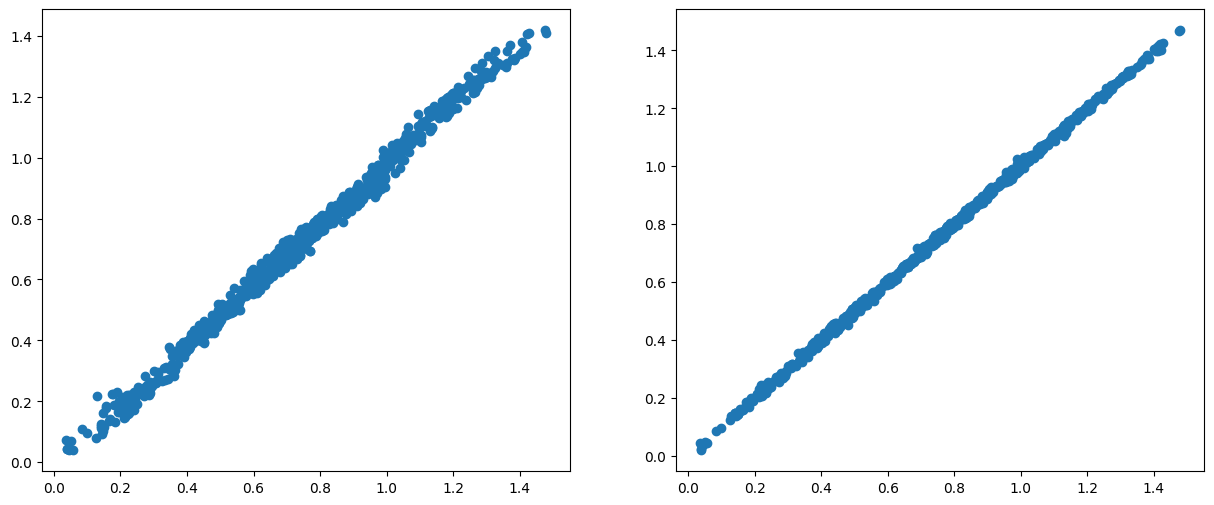

In [94]:
with torch.no_grad():
    model = DNNS1(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    model.load_state_dict(torch.load('./EXB'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    
    print('(Train) MSPE: ', criterion(y_test, MBSy), '| (Test) MSPE: ', criterion(y_test, MPSy))
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.scatter(y_test, model(X_test).detach())
    plt.subplot(1,2,2)
    plt.scatter(y_test, DPS(X_test).detach())

## 2DNN-S

In [30]:
class MPSv3(nn.Module):
    def __init__(self, input_dim, degree, num_knots, num_neurons, output_dim, bias):
        super(MPSv3, self).__init__()
        self.num_neurons = num_neurons
        self.num_knots = num_knots
        self.ln1 = nn.Linear(input_dim, num_neurons)
        self.nm1 = NormLayer() 
        self.sp1 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.nm2 = NormLayer() 
        self.sp2 = PRODBSplineLayerMultiFeature(input_dim = 1, degree = degree, num_knots = num_knots, num_neurons = num_neurons, output_dim= output_dim, bias = True)
        self.ln2 = nn.Linear(num_neurons, output_dim)
        self.relu = nn.ReLU()
        self.inter = {}
        
    def forward(self, x):
        ln1out = self.ln1(x)
        ln1out = self.nm1(ln1out)
        
        device = ln1out.device
        batch_size, _ = x.size()
        
        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp1out = self.sp1(ln1out)
        bslist = self.sp1.inter['basic']
        
        self.inter['ebasic'] = bslist
        self.inter['basic'] = sp1out

        # # # # # # # # # # # # # #
        #         SPLINE 1        #
        # # # # # # # # # # # # # #
        
        sp2out = self.sp2(ln1out)
        bslist2 = self.sp2.inter['basic']
        
        self.inter['ebasic2'] = bslist2
        self.inter['basic2'] = sp2out

        ln2out = self.ln2(sp2out)
        #ln2out = self.relu(ln2out)
        
        return ln2out

In [33]:
MBS(X_train)

KeyError: 'basic'

In [31]:
nm = 50; dg = 3; L = 1; nk = 15; Fin = ndim; Fout = 1;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


MBS = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
print('Number of Parameters: ', num_para(MBS))

################################################
#        Example 3 use learning rate 1e-3      #
################################################
#    Example 1 and 2 use learning rate 1e-2    #
################################################

learning_r = 1e-1
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(MBS.parameters(), lr=learning_r)

Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999

for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = MBS(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            optimizer = torch.optim.Adam(MBS.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(MBS.state_dict(), './1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')


with torch.no_grad():
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

Number of Parameters:  2201


KeyError: 'basic'

tensor(0.0009)


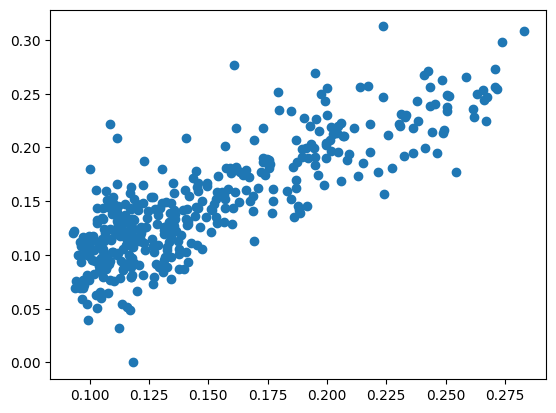

In [285]:
with torch.no_grad():
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))
    plt.scatter(y_test, eval_model(X_test).detach())

In [53]:
def ECM(model, num_neurons, num_knots, initial_xi = 1, initial_sigma = 1, initial_lambda = 1e-4, L = None):
    lambdab = initial_lambda
    sigma = initial_sigma
    xi = initial_xi

    if L == 1:
        B = model.inter['ebasic']
        By = model.inter['basic']
        WB = model.sp1.control_p
    else:
        B = model.inter['ebasic2']
        By = model.inter['basic2']
        WB = model.sp2.control_p
        
    DB = diag_mat_weights(WB.size()[0]).to(device)
    size = B.size()[1]
    S = DB.T @ DB
    Cov_a = (xi**2)* torch.linalg.pinv(S)
    Cov_e = torch.eye(size*num_neurons)* sigma
    
    block_y = torch.reshape(By, (-1,1))
    flatB = B.view(num_neurons, num_knots, size)
        
    sqr_xi= 0
    sqr_sig = 0
    
    for i in range(num_neurons):
        Ncov = (Cov_a -(Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)]) @ flatB[i].T @ Cov_a))
        Nmu = (Cov_a @ flatB[i]) @ (torch.linalg.pinv(flatB[i].T @ Cov_a @ flatB[i] + Cov_e[size*i:size*(i+1),size*i:size*(i+1)])) @ By[:,i].reshape(-1,1)
        
        first_xi = S @ Ncov
        second_xi = (Nmu.T @ S @ Nmu)
        sqr_xi += torch.trace(first_xi) + second_xi
            
        first_sig = torch.norm(By[:,i])
        second_sig = 2 * (By[:,i] @ flatB[i].T) @ Nmu 
        third_sig = torch.trace((flatB[i] @ flatB[i].T) @ Ncov)
        four_sig = (Nmu.T @ flatB[i] @ flatB[i].T @ Nmu)
        
        sqr_sig += (first_sig + second_sig + third_sig + four_sig)
    
    sqr_xi /= num_neurons
    sqr_sig /= (num_neurons*size)
    
    Lambda = sqr_sig/sqr_xi
    
    return Lambda.item()

In [64]:
with torch.no_grad():
    print('------------------------------------------')
    print('Before adding penalty ... ')
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print('Training Error: ', np.round(criterion(y_train, eval_model(X_train).detach()).item(), 5), ' | Testing Error: ', np.round(criterion(y_test, eval_model(X_test).detach()).item(), 5))
    print('------------------------------------------')
    print('After adding penalty ... ')

    
    WB = eval_model.sp1.control_p
    DB = diag_mat_weights(WB.size()[0], 'second').to(device)
    BestGCV = 9999
    
    for i in range(10):
        MPSy = eval_model(X_train)
        LambdaB1 = ECM(model = eval_model, num_neurons = nm, num_knots = nk, L = 1)
        LambdaB2 = ECM(model = eval_model, num_neurons = nm, num_knots = nk, L = 2)
        
        B1 = eval_model.inter['ebasic']
        B2 = eval_model.inter['ebasic2']
        P2 = (torch.linalg.pinv(B2.T @ B2) @ B2.T @ B2)
        
        By1 = eval_model.inter['basic']
        By2 = eval_model.inter['basic2']
        
        size1 = B1.size()[1]
        size2 = B2.size()[1]

        B1 = B1.view(nm, nk, size1)
        B2 = B2.view(nm, nk, size2)

        NW1 = torch.empty((nk, nm))
        NW2 = torch.empty((nk, nm))
        NB1 = torch.empty((nm))
        NB2 = torch.empty((nm))
        for i in range(nm):
            B1y = By1[:,i] - eval_model.sp1.bias.data[i]
            B2y = By2[:,i] - eval_model.sp2.bias.data[i]

            BB1 = B1[i].T
            BB2 = B2[i].T
            PB1 = (torch.linalg.pinv(BB1.T @ BB1) @ BB1.T @ BB1)
            PB2 = (torch.linalg.pinv(BB2.T @ BB2) @ BB2.T @ BB2)

            # Update the weights and bias
            NW1[:, i] = (torch.inverse(BB1.T @ BB1 + (LambdaB1/size1) * (DB.T @ DB)) @ BB1.T @ B1y)
            NW2[:, i] = (torch.inverse(BB2.T @ BB2 + (LambdaB2/size2) * (DB.T @ DB)) @ BB2.T @ B2y)
            NB1[i] = torch.mean(By1[:,i] - (NW1[:,i] @ BB1.T))
            NB2[i] = torch.mean(By2[:,i] - (NW2[:,i] @ BB2.T))
            
        # update the weight
        getattr(eval_model.sp1, 'control_p').data = NW1
        getattr(eval_model.sp2, 'control_p').data = NW2
        getattr(eval_model.sp1, 'bias').data = NB1
        getattr(eval_model.sp2, 'bias').data = NB2
        

        MPSy = eval_model(X_train)
        trainloss = np.round(criterion(y_train, MPSy.detach()).item(), 5)
        GCV = np.round((torch.norm(y_train - MPSy)/(size2-torch.trace(P2))).item(), 5)
        
        if GCV < BestGCV:
            BestLambdaB1, BestLambdaB2 = LambdaB1, LambdaB2
            BestGCV = GCV
            
        MPSy = eval_model(X_test)
        print('Lambda: ', np.round(LambdaB1, 5),' and ', np.round(LambdaB2, 5),'| Training Loss: ', trainloss,'| GCV: ', GCV,' | Testing Error: ', np.round(criterion(y_test, MPSy.detach()).item(), 5))

------------------------------------------
Before adding penalty ... 
Training Error:  0.00285  | Testing Error:  0.00369
------------------------------------------
After adding penalty ... 
Lambda:  0.38437  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00368
Lambda:  0.38445  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00368
Lambda:  0.38453  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00368
Lambda:  0.38461  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00367
Lambda:  0.38469  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00367
Lambda:  0.38477  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00367
Lambda:  0.38484  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00367
Lambda:  0.38492  and  0.05236 | Training Loss:  0.00284 | GCV:  0.00198  | Testing Error:  0.00367
Lambda:  

In [ ]:
nm = 50; dg = 3; L = 1; nk = 15; Fin = ndim; Fout = 1;

eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
eval_model.load_state_dict(torch.load('./1BestMBSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))


################################################
#        Example 3 use learning rate 1e-3      #
################################################
#    Example 1 and 2 use learning rate 1e-2    #
################################################
learning_r = 1e-2

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(eval_model.parameters(), lr=learning_r)

fast_tune = 5001; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999
n = X_train.size()[0]

for t in range(1, fast_tune):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = eval_model(X_train)
    WB1 = eval_model.sp1.control_p.data; WB2 = eval_model.sp2.control_p.data
    DB1 = diag_mat_weights(WB1.size()[0]).to(device); DB2 = diag_mat_weights(WB2.size()[0]).to(device)

    loss = criterion(y_train, pyb_af) + (BestLambdaB1/n) * torch.norm(DB1 @ WB1) + (BestLambdaB2/n) * torch.norm(DB2 @ WB2)
    bloss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 50 == 0:
        with torch.no_grad():
            print(criterion(y_test, eval_model(X_test).detach()))
            
    #print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')


with torch.no_grad():
    print(criterion(y_test, eval_model(X_test).detach()))

## Multi-Linear

In [51]:
class MLNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLNet, self).__init__()
        self.ln1 = nn.Linear(input_dim, 30)
        self.relu1 = nn.ReLU()
        self.ln2 = nn.Linear(30, 30)
        self.relu2 = nn.ReLU()
        self.ln3 = nn.Linear(30, output_dim)
        self.relu3 = nn.ReLU()
        
    def forward(self, x):
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.ln3(x)
        output = self.relu3(x)
        
        return output

In [72]:
ML = MLNet(ndim, 1)
print('Number of parameter: ', num_para(ML))
learning_r = 1e-4
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(ML.parameters(), lr=learning_r)
Iteration = 10000; bloss_list = []; tor = 1e-5; lr_tor = 1e-6
patientc = 10; patientr = 5; tpat = 0; bloss = 9999

for t in range(Iteration):

    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = ML(X_train)
    loss = criterion(y_train, pyb_af); bloss_list.append(loss.item())
    
    if (t > 0) and ((bloss_list[t-1]-bloss_list[t])<tor):        
        if (tpat % patientr) == 0:
            learning_r *= 0.2 
            tpat += 1
            #print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(ML.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
        
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            #torch.save(MBS.state_dict(), './EXA'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk)+'data'+str(d+1))
            bloss = loss.item()
            tpat = 0
        tpat += 1

    if tpat == patientc:
        print('Convergence!')
        break
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')

Current loss:  0.5207098126411438  | , previous best loss:  9999  | saving best model ...
| Epoch:  1 / 10000  | Loss:  0.5207  |
Current loss:  0.5193433165550232  | , previous best loss:  0.5207098126411438  | saving best model ...
| Epoch:  2 / 10000  | Loss:  0.5193  |
Current loss:  0.5179778337478638  | , previous best loss:  0.5193433165550232  | saving best model ...
| Epoch:  3 / 10000  | Loss:  0.518  |
Current loss:  0.5166123509407043  | , previous best loss:  0.5179778337478638  | saving best model ...
| Epoch:  4 / 10000  | Loss:  0.5166  |
Current loss:  0.5152472853660583  | , previous best loss:  0.5166123509407043  | saving best model ...
| Epoch:  5 / 10000  | Loss:  0.5152  |
Current loss:  0.5138829350471497  | , previous best loss:  0.5152472853660583  | saving best model ...
| Epoch:  6 / 10000  | Loss:  0.5139  |
Current loss:  0.5125197768211365  | , previous best loss:  0.5138829350471497  | saving best model ...
| Epoch:  7 / 10000  | Loss:  0.5125  |
Current

In [73]:
with torch.no_grad():
    print(criterion(y_test, ML(X_test).detach()))

tensor(0.0019)


In [485]:
MPS = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
learning_r = 1e-2
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(MPS.parameters(), lr=learning_r)

Iteration = 10000
ploss_list = []
bloss = 9999

tpat = 0
patientc = 20
patientr = 5
lr_tor = 1e-7
n = X_train.size()[0]

for t in range(Iteration):
    # Forward pass: Compute predicted y by passing x to the modelsp
    pyb_af = MPS(X_train)
    
    # Extracted the feature from model
    WB1 = MPS.sp1.control_p; DB1 = diag_mat_weights(WB1.size()[0]).to(device)
    
    # Calculate the MSELoss & penalty
    loss = criterion(y_train, pyb_af) 
    penalty = LambdaB * torch.norm(DB1 @ WB1)*(1/nm) 
    #penalty = 4.9 * torch.norm(DB1 @ WB1)*(1/n) 
    #+ (Lambdadict['L']/n) * torch.norm(DL @ WL.T)
    loss += penalty
    
    ploss_list.append(loss.item())
    

    if (t > 0) and ((ploss_list[t-1]-ploss_list[t])<tor):        
        if  (tpat % patientr) == 0 :
            learning_r *= 0.2 
            tpat += 1
            print('Learning rate reduce to ', learning_r)
            optimizer = torch.optim.Adam(MPS.parameters(), lr=learning_r)
            if learning_r <= lr_tor:
                print('Convergence!')
                break
        elif tpat < patientc:
            tpat += 1
            pass
        else:
            print('Convergence!')
            break
    else:
        if loss < bloss:
            print('Current loss: ', loss.item(), ' | , previous best loss: ', bloss, ' | saving best model ...')
            torch.save(MPS.state_dict(), './1BestMPSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk))
            bloss = loss.item()
            tpat = 0
        tpat += 1
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('| Epoch: ',t+1,'/',str(Iteration),' | Loss: ', np.round(loss.item(), 4),' |')

Current loss:  0.7689186334609985  | , previous best loss:  9999  | saving best model ...
| Epoch:  1 / 10000  | Loss:  0.7689  |
| Epoch:  2 / 10000  | Loss:  0.8576  |
Current loss:  0.7505857944488525  | , previous best loss:  0.7689186334609985  | saving best model ...
| Epoch:  3 / 10000  | Loss:  0.7506  |
Current loss:  0.73035728931427  | , previous best loss:  0.7505857944488525  | saving best model ...
| Epoch:  4 / 10000  | Loss:  0.7304  |
| Epoch:  5 / 10000  | Loss:  0.7699  |
| Epoch:  6 / 10000  | Loss:  0.7433  |
Current loss:  0.7008974552154541  | , previous best loss:  0.73035728931427  | saving best model ...
| Epoch:  7 / 10000  | Loss:  0.7009  |
Current loss:  0.6980769634246826  | , previous best loss:  0.7008974552154541  | saving best model ...
| Epoch:  8 / 10000  | Loss:  0.6981  |
| Epoch:  9 / 10000  | Loss:  0.7145  |
| Epoch:  10 / 10000  | Loss:  0.7072  |
Current loss:  0.6810963153839111  | , previous best loss:  0.6980769634246826  | saving best mod

In [492]:
with torch.no_grad():
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./1BestMPSn'+str(X_train.size()[0])+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

tensor(1.5192)


In [490]:
MPSy = eval_model(X_train)
LambdaB = ECM(model = eval_model, num_neurons = nm, num_knots = nk)
print('Lambda: ', LambdaB)

Lambda:  0.5584757328033447


## 

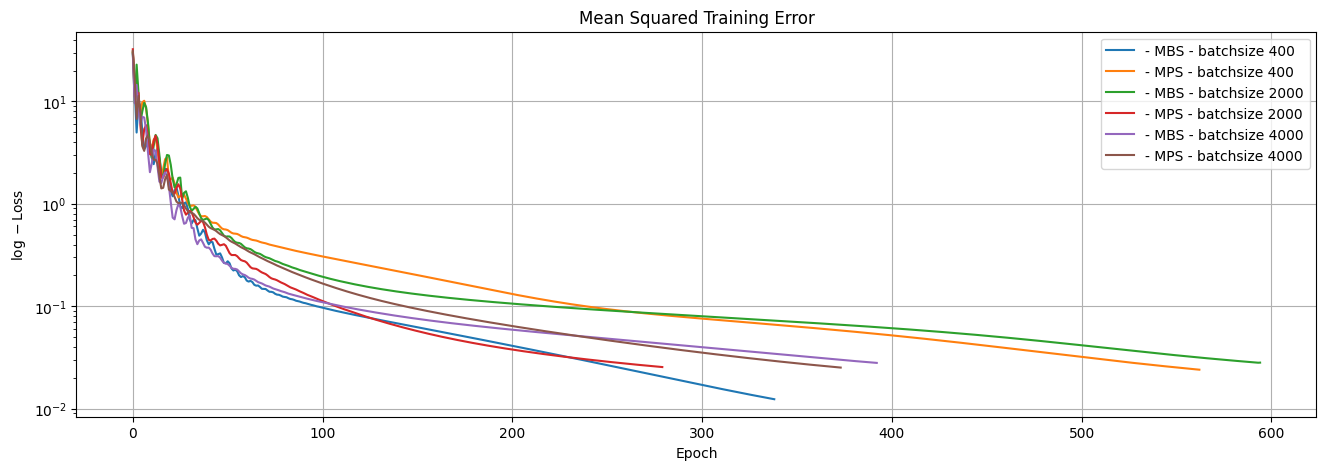

In [249]:
plt.figure(figsize=(16,5))
plt.plot(np.arange(len(Lossdict['MBS400'][:-4])), Lossdict['MBS400'][:-4], label = '- MBS - batchsize 400')
plt.plot(np.arange(len(Lossdict['MPS400'][:-27])), Lossdict['MPS400'][:-27], label = '- MPS - batchsize 400')
plt.plot(np.arange(len(Lossdict['MBS2000'][:-27])), Lossdict['MBS2000'][:-27], label = '- MBS - batchsize 2000')
plt.plot(np.arange(len(Lossdict['MPS2000'][:-6])), Lossdict['MPS2000'][:-6], label = '- MPS - batchsize 2000')
plt.plot(np.arange(len(Lossdict['MBS4000'][:-35])), Lossdict['MBS4000'][:-35], label = '- MBS - batchsize 4000')
plt.plot(np.arange(len(Lossdict['MPS4000'][:-6])), Lossdict['MPS4000'][:-6], label = '- MPS - batchsize 4000')
plt.yscale("log")
plt.title('Mean Squared Training Error')
plt.xlabel('Epoch')
plt.ylabel('$\log-$Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.grid()

### Parameter sum

In [358]:
with torch.no_grad():
    X_test = torch.load('../Dataset/train400.pt', weights_only = True)['X_test']
    y_test = torch.load('../Dataset/train400.pt', weights_only = True)['y_test']

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMBSn400'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMPSn400'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    X_test = torch.load('../Dataset/train2000.pt', weights_only = True)['X_test']
    y_test = torch.load('../Dataset/train2000.pt', weights_only = True)['y_test']

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMBSn2000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))
    
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMPSn2000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    X_test = torch.load('../Dataset/train4000.pt', weights_only = True)['X_test']
    y_test = torch.load('../Dataset/train4000.pt', weights_only = True)['y_test']
    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMBSn4000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

    eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
    eval_model.load_state_dict(torch.load('./BestMPSn4000'+'h'+str(nm)+'k'+str(nk), weights_only = True))
    print(criterion(y_test, eval_model(X_test).detach()))

tensor(0.0359)
tensor(0.0546)
tensor(0.0302)
tensor(0.0265)
tensor(0.0303)
tensor(0.0266)


In [405]:
cat_dict = {}
sizel = ['400', '2000', '4000']

for s in sizel:
    with torch.no_grad():
        eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        eval_model.load_state_dict(torch.load('./BestMBSn'+s+'h'+str(nm)+'k'+str(nk), weights_only = True))
        
    cat_par = None
    for name, param in eval_model.named_parameters():
        if param.requires_grad:
            if cat_par is None:
                cat_par = param.data.reshape(-1,1)
            else:
                cat_par = torch.cat([cat_par, param.data.reshape(-1,1)], dim = 0)

    par = cat_par.detach().numpy().reshape(-1)
    par = par * np.std(par)
    
    cat_dict['b'+s] = list(par)
    
sizel = ['400', '2000', '4000']

for s in sizel:
    with torch.no_grad():
        eval_model = MPSv3(input_dim = Fin, degree = dg, num_knots = nk, num_neurons = nm, output_dim = Fout, bias = True).to(device)
        eval_model.load_state_dict(torch.load('./BestMPSn'+s+'h'+str(nm)+'k'+str(nk), weights_only = True))
        
    cat_par = None
    for name, param in eval_model.named_parameters():
        if param.requires_grad:
            if cat_par is None:
                cat_par = param.data.reshape(-1,1)
            else:
                cat_par = torch.cat([cat_par, param.data.reshape(-1,1)], dim = 0)

    par = cat_par.detach().numpy().reshape(-1)
    par *= np.std(par)
    cat_dict['p'+s] = list(par)

In [409]:
cat = ['MBS(400)'] * len(cat_par) + ['MPS(400)'] * len(cat_par) + ['MBS(2000'] * len(cat_par) + ['MPS(2000)'] * len(cat_par) + ['MBS(4000)'] * len(cat_par)  + ['MPS(4000)'] * len(cat_par)
para = cat_dict['b400'] +  cat_dict['p400']  + cat_dict['b2000'] + cat_dict['p2000'] + cat_dict['b4000'] + cat_dict['p4000']
df = pd.DataFrame({'Class': cat, 'para': para})

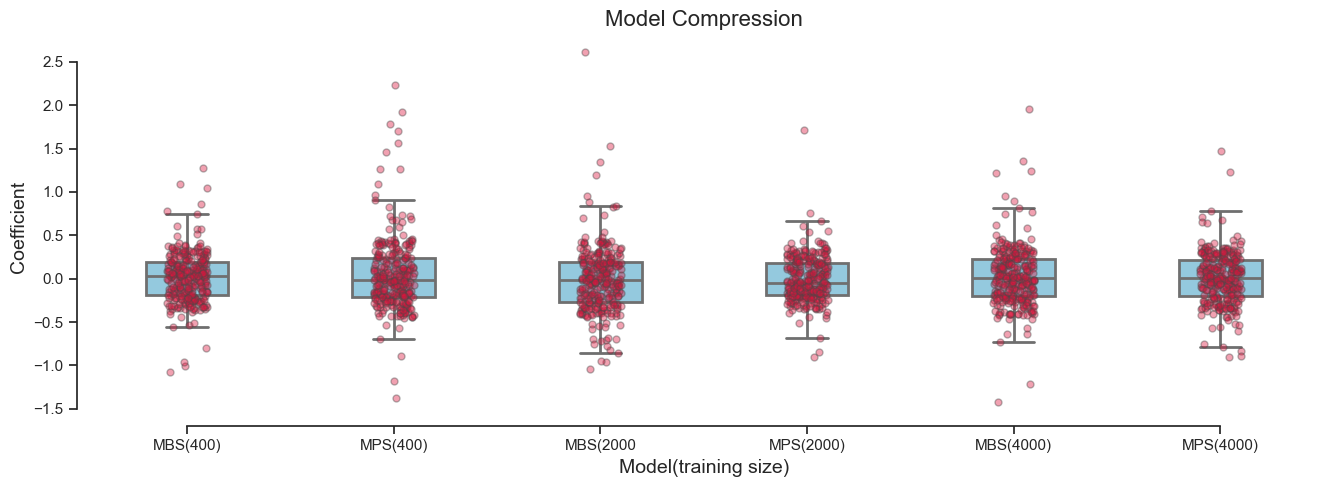

In [413]:
# Change some of seaborn's style settings with `sns.set()`
plt.figure(figsize = (16, 5))
sns.set(
        style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (6, 9),      # width = 6, height = 9
            "figure.facecolor": "white",  # Figure colour
            "axes.facecolor": "white"})  # Axes colour# Box plot
b = sns.boxplot(data = df,           
                    x = "Class",       # x axis column from data
                    y = "para",       # y axis column from data
                    width = 0.4,        # The width of the boxes
                    color = "skyblue",  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers# Strip plot
b = sns.stripplot(data = df,          
                      x = "Class",      # x axis column from data
                      y = "para",      # y axis column from data
                      color = "crimson", # Colours the dots
                      linewidth = 1,     # Dot outline width
                      alpha = 0.4)       # Makes them transparent# Set the y axis and font size
b.set_ylabel("Coefficient", fontsize = 14)# Set the x axis label and font size
b.set_xlabel("Model(training size)", fontsize = 14)# Set the plot title with the pval variable and font size
b.set_title("Model Compression", fontsize = 16)# Remove axis spines
sns.despine(offset = 5, trim = True)# Show the figure
b.get_figure();

plt.savefig('boxcoef.png')